# Case study
Given a user’s past reviews on Yelp (available from yelp-challenge dataset),

When the user writes a review for a business she hasn't reviewed before,

How likely will it be a Five-Star review?

- Load data
- Visualize the data
- Featurize the data
- Join tables to populate the features
- Model the data: Logistic regression
- Evaluate the model
- Make prediction with the model

## Data source
[Yelp Dataset Round 13](https://www.yelp.com/dataset)

We took the full set of business, user, and review data in json format.


# Step 1: Load the Data

We store data in Pandas DataFrames.

We load three types of data from the dataset, each stored in a separate df.

`set_index()`: tells pandas to index the df by the column specified in the param.

In [15]:
import pandas as pd

CHUNK_SIZE = 10000
PATH = '~/Desktop/yelp_dataset/'

In [16]:
%%time
biz_df = pd.concat(pd.read_json(PATH + 'business.json', lines=True, chunksize=CHUNK_SIZE))
biz_df.head()

CPU times: user 3.69 s, sys: 569 ms, total: 4.26 s
Wall time: 4.34 s


,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
3,"15655 W Roosevelt St, Ste 237",None,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ
4,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC


In [17]:
biz_df = biz_df.set_index('business_id')
biz_df.head()

,address,attributes,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
business_id,,,,,,,,,,,,,
1SWheh84yJXfytovILXOAQ,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
QXAEGFB4oINsVuTFxEYKFQ,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
gnKjwL_1w79qoiV3IC_xQQ,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
xvX2CttrVhyG2z1dFg_0xw,"15655 W Roosevelt St, Ste 237",None,"Insurance, Financial Services",Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ
HhyxOkGAM07SRYtlQ4wMFQ,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...","Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC


In [18]:
%%time
review_df = pd.concat(pd.read_json(PATH + 'review.json', lines=True, chunksize=CHUNK_SIZE))
review_df = review_df.set_index('review_id')

CPU times: user 1min 37s, sys: 27.3 s, total: 2min 4s
Wall time: 2min 12s


In [19]:
%%time
user_df = pd.concat(pd.read_json(PATH + 'user.json', lines=True, chunksize=CHUNK_SIZE))
user_df = user_df.set_index('user_id')

CPU times: user 41.8 s, sys: 17.4 s, total: 59.2 s
Wall time: 1min 4s


## Useful Functions to Explore the DataFrames
`review_df.head()`: Print top rows in the data frame.

`review_df.describe()`: Generate various summary statistics, mean, max, count, etc.

In [20]:
review_df.head()

,business_id,cool,date,funny,stars,text,useful,user_id
review_id,,,,,,,,
Q1sbwvVQXV2734tPgoKj4Q,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,1,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA
GJXCdrto3ASJOqKeVWPi6Q,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,5,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg
2TzJjDVDEuAW6MR5Vuc1ug,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,5,I have to say that this office really has it t...,3,n6-Gk65cPZL6Uz8qRm3NYw
yi0R0Ugj_xUx_Nek0-_Qig,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,5,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg
11a8sVPMUFtaC7_ABRkmtw,b1b1eb3uo-w561D0ZfCEiQ,0,2018-01-30 23:07:38,0,1,Today was my second out of three sessions I ha...,7,ssoyf2_x0EQMed6fgHeMyQ


In [21]:
review_df.dtypes

business_id            object
cool                    int64
date           datetime64[ns]
funny                   int64
stars                   int64
text                   object
useful                  int64
user_id                object
dtype: object

In [22]:
review_df.describe()

,cool,funny,stars,useful
count,6.685900e+06,6.685900e+06,6.685900e+06,6.685900e+06
mean,5.787708e-01,4.827667e-01,3.716199e+00,1.354134e+00
std,2.359024e+00,2.378646e+00,1.463643e+00,3.700192e+00
min,-1.000000e+00,0.000000e+00,1.000000e+00,-1.000000e+00
25%,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00
75%,1.000000e+00,0.000000e+00,5.000000e+00,2.000000e+00
max,5.060000e+02,1.290000e+03,5.000000e+00,1.241000e+03


In [23]:
review_df.cool.describe().apply(lambda x: format(x, 'f'))

count    6685900.000000
mean           0.578771
std            2.359024
min           -1.000000
25%            0.000000
50%            0.000000
75%            1.000000
max          506.000000
Name: cool, dtype: object

# Step 2: Explore & Visualize the Data

## Example 1: Plot Review Star Rating Distribution

First ask yourself this question: 

Among all the reviews available in the dataset, what percentage of them are 5 star? 

One common mis-conception about Yelp, is that folks only come to Yelp to complaint about their negative experiences with a business, so most of the reviews "should" be low rating. 

However, this is a misconception, according to the below graph we plot, using the Yelp Open Dataset.

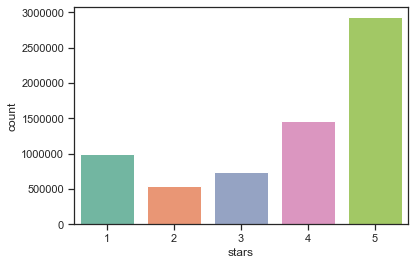

In [24]:
import seaborn as sns
%matplotlib inline

ax = sns.countplot(x='stars', data=review_df)

## Example 2: Plot Review Star Rating Distribution by year

From below graph,
- healthy growth over the years, on the amount of reviews people wrote every year. 
- later years, there seems to be a shift towards 5 star reviews. 

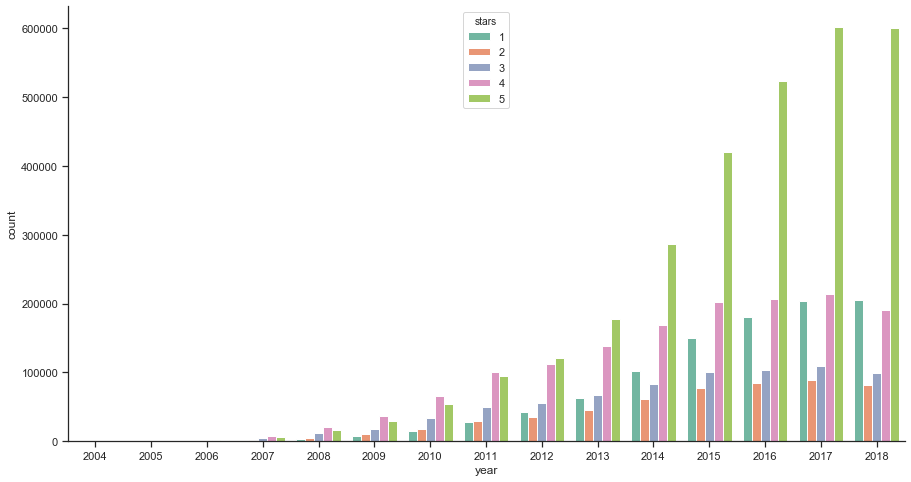

In [25]:
# Set context to "talk" for figure aesthetics 
sns.set_context(context="talk")
# set plot figure size to larger
sns.set(palette='Set2', rc={"figure.figsize": (15, 8)}, style="ticks")

# Convert to datetime dtype so we can strip out the year
review_df['year'] = pd.to_datetime(review_df['date']).dt.year
ax = sns.countplot(x='year', data=review_df, hue='stars')
# Removing spines
sns.despine()

# clean up
review_df.drop(['year'], axis=1, inplace=True)

# Step 3: Generate the Features

# 3.1 Examples Feature Extractions & Conversions

- Convert date string to date delta
  - For example, `business_age`
- Convert strings to categorical features
  - For example, `noise_level`: `{'quiet', 'loud', 'very loud'}`.
- Drop unused features
  - For example, `business_name`

In [26]:
# compute days in between date and max value in date
def calculate_date_delta(df, column):
    to_column = column + '_delta'
    datetime = pd.to_datetime(df[column])
    time_delta = datetime.max() - datetime
    df[to_column] = time_delta.apply(lambda x: x.days)
    df.drop(column, axis=1, inplace=True)

In [27]:
# compute length of string
def to_length(df, column):
    to_column = column + '_len'
    df[to_column] = df[column].apply(lambda x: len(x))
    df.drop(column, axis=1, inplace=True)

In [28]:
def drop_columns(df, columns):
    for column in columns:
        df.drop(column, axis=1, inplace=True)

In [29]:
def to_boolean(df, columns):
    for column in columns:
        to_column = column + '_bool'
        df[to_column] = df[column].apply(lambda x: bool(x))
        df.drop(column, axis=1, inplace=True)

In [30]:
# Value used to replace NULL as Logistic Regression can't work with missing value.
# XXX(xun): For many features, 0.0 is a legit value, hence 0.0 isn't a very good fallback value to use. Average is maybe better? 
FILL_WITH = 0.0

In [31]:
def to_category(df, columns):
    for column in columns:
        df[column] = df[column].astype('category')
        # add FILL_WITH category for fillna()
        if (FILL_WITH not in df[column].cat.categories):
            df[column] = df[column].cat.add_categories([FILL_WITH])
        print(f'categories for {key} include {df[key].cat.categories}')

In [32]:
def category_rename_to_int(df, columns):
    for column in columns:
        df[column].cat.remove_unused_categories()
        size = len(df[column].cat.categories)
        print(f'column {column} has {size} columns, including {df[column].cat.categories}')
        df[column] = df[column].cat.rename_categories(range(1, size+1))
        print(f'=> {df[column].cat.categories}')

In [33]:
# review df
calculate_date_delta(df=review_df, column='date')
to_length(df=review_df, column='text') # next round, we could run NLP (sentiment, bag of words) on the text
review_df.fillna(value=FILL_WITH, inplace=True)

review_df.columns.values

array(['business_id', 'cool', 'funny', 'stars', 'useful', 'user_id',
       'date_delta', 'text_len'], dtype=object)

In [34]:
# user df
calculate_date_delta(df=user_df, column='yelping_since')
to_length(df=user_df, column='friends')
to_length(df=user_df, column='elite')
drop_columns(df=user_df, columns=['name'])
user_df.fillna(value=FILL_WITH, inplace=True)

user_df.columns.values

array(['average_stars', 'compliment_cool', 'compliment_cute',
       'compliment_funny', 'compliment_hot', 'compliment_list',
       'compliment_more', 'compliment_note', 'compliment_photos',
       'compliment_plain', 'compliment_profile', 'compliment_writer',
       'cool', 'fans', 'funny', 'review_count', 'useful',
       'yelping_since_delta', 'friends_len', 'elite_len'], dtype=object)

In [35]:
# biz df
drop_columns(
    df=biz_df,
    columns=[
        'postal_code', # needs to convert to categorical if use as a feature
        'name',
        'city',
        'address',
        'state',
        'categories', # can be converted to separate columns as category types
        'longitude',
        'latitude',
        'hours', # can do fancy conversions to categories like 'morning', 'night', '24 hours', etc.
        'attributes', # can be converted to separate columns as category types
    ]
)
# # Split dictionary inside a Pandas Column (eg 'attributes') into Separate Columns
# to_cat_columns = [
#     'attributes'
# ]
# df_flat = pd.DataFrame(biz_df['attributes'].tolist())

# to_category(
#     df=df_flat,
#     columns=df_flat.columns,
# )
# category_rename_to_int(
#     df=biz_df,
#     columns=to_cat_columns,
# )
biz_df.fillna(value=FILL_WITH, inplace=True)

# # print out all the unique values, help clean up data to be float type
# for column in biz_df.columns:
#     print(column)
#     print(biz_df[column])
    
biz_df.columns.values

array(['is_open', 'review_count', 'stars'], dtype=object)

In [36]:
# rename the columns to be prefixed by the df
def rename(df, prefix):
    for column in df.columns.values:
        if column in {'user_id', 'review_id', 'business_id'}:
            continue
        df[prefix + column] = df[column]
        df.drop(column, axis=1, inplace=True)

rename(biz_df, 'biz_')
rename(user_df, 'user_')
rename(review_df, 'review_')

In [37]:
# The `user_df` DataFrame is already indexed by the join key (`user_id`). Make sure it's on the right side of join.
review_join_user = review_df.join(user_df, on='user_id')

In [38]:
review_join_user_join_biz = review_join_user.join(biz_df, on='business_id')

In [39]:
drop_columns(df=review_join_user_join_biz, columns=['user_id', 'business_id'])

# Step 4: Train a Model

The process of training an ML model involves providing an ML algorithm (that is, the learning algorithm) with training data to learn from. The term ML model refers to the model artifact that is created by the training process.


## 4.1 Arrange Data into a Feature Matrix and a Target Array

**Feature matrix** X: 

All features gathered from business, user, and review dataframes.

Two-dimensional array of features with shape = (n_samples, n_features)

**Target array** y: 

What we'd like to predict: Whether the review is Five-star or not.

Array of labels with shape = (n_samples)

In [40]:
# Target y is whether a review is five-star (True / False)
y = review_join_user_join_biz.review_stars.apply(lambda x: x == 5)

# Exclude the `stars` columns from the feature matrix, since it is the target
X = review_join_user_join_biz
review_join_user_join_biz.drop('review_stars', axis=1, inplace=True)

# get the feature names - this will be useful for the model visualization and feature analysis
features = X.columns.values

## 4.2 Split Training and Testing Set

- Training set: used for an machine learning algorithm to train from. 
- Testing set: used to to estimate / evaluate how well the model has been trained.

Split them so that we don’t evaluate on the same dataset we train from

In [41]:
from sklearn.model_selection import train_test_split

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [42]:
print(f'training data shape{X_train.shape}')
print(f'test data shape{X_test.shape}')
print(f'converted label data shape{y_train.shape}')
print(f'features{features}')

training data shape(5014425, 28)
test data shape(1671475, 28)
converted label data shape(5014425,)
features['review_cool' 'review_funny' 'review_useful' 'review_date_delta'
 'review_text_len' 'user_average_stars' 'user_compliment_cool'
 'user_compliment_cute' 'user_compliment_funny' 'user_compliment_hot'
 'user_compliment_list' 'user_compliment_more' 'user_compliment_note'
 'user_compliment_photos' 'user_compliment_plain'
 'user_compliment_profile' 'user_compliment_writer' 'user_cool'
 'user_fans' 'user_funny' 'user_review_count' 'user_useful'
 'user_yelping_since_delta' 'user_friends_len' 'user_elite_len'
 'biz_is_open' 'biz_review_count' 'biz_stars']


## 4.3 What Model to Use? 

Some Examples
- Decision Tree: predicts the value of a target variable by learning simple decision rules inferred from the data features
- Random Forest: combines de-correlated trees, where each tree is built from a bootstrap sample and node splits are calculated from random feature subsets
- Ensemble Model: combine predictions of several models in order to improve the accuracy (decrease bias) and robustness (decrease variance) over a single model

The model we are using here: **Logistic Regression**

Logistic regression estimates the probability of a binary response based on one or more features.
The probabilities describing the possible outcomes of a single trial are modeled using a logistic function.
Here we estimate the probability of a review being five-star.

## 4.4 Normalize the Features

Standardize features by removing the mean and scaling to unit variance.
- Logistic Regression requires all features been normalized.

In [43]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train.astype(float))

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4.5 Fit the model

In [44]:
from sklearn import linear_model

# Build model using default parameter values
lrc = linear_model.LogisticRegression(solver='lbfgs')

In [45]:
%%time
lrc_fit = lrc.fit(X_train_scaled, y_train)
y_pred = lrc_fit.predict(X_test_scaled)

CPU times: user 2min 18s, sys: 5.28 s, total: 2min 23s
Wall time: 25.9 s


In [46]:
# Model feature importance
sorted(zip(X_train.columns.values, lrc_fit.coef_[0]), key=lambda t: abs(t[1]), reverse=True)

[('user_average_stars', 1.0505022559705588),
 ('user_cool', -1.0107147161998125),
 ('biz_stars', 0.9244950972020263),
 ('user_useful', 0.739631589074003),
 ('review_cool', 0.42185588070521624),
 ('user_funny', 0.36979409084888004),
 ('review_funny', -0.30328739629508933),
 ('review_text_len', -0.29460789936244713),
 ('user_review_count', -0.2640214949901645),
 ('user_elite_len', -0.22988825701965537),
 ('review_useful', -0.1639790811619176),
 ('review_date_delta', -0.10498557408047383),
 ('user_compliment_photos', -0.08573227836979479),
 ('biz_review_count', -0.08050395963857561),
 ('user_compliment_list', 0.06258784843517577),
 ('user_compliment_writer', 0.06143033366093664),
 ('user_compliment_more', -0.0558164571611332),
 ('biz_is_open', 0.04046167137249145),
 ('user_compliment_hot', 0.03349402333328175),
 ('user_compliment_plain', -0.03016012210136316),
 ('user_fans', 0.02146529947796156),
 ('user_compliment_profile', -0.017994900467357872),
 ('user_compliment_cute', 0.014798428963

# Step 5: Evaluate the Model

## 5.1 Make Prediction with the Model

Process: 
- Randomly pick a few anonymous users from the dataset.
- Randomly pick a few businesses from the dataset.
- Predict whether the user will give the business a review with five-star rating.

In [47]:
from IPython.display import display, HTML

def predict_given_user_biz(user, biz, review_df):
    a_user = user.copy()
    a_biz = biz.copy()
    # The review hasn't actually be written yet.
    # XXX(xun): We fake the feature using global mean/avg values to create a "general" review. 
    #   There are many other/better ways to fake the review to be more representative
    #   (e.g. draw from the real distribution, or avg of the user / the biz). 
    a_review = pd.DataFrame(
        {
            'user_id': a_user.index,
            'business_id': a_biz.index,
            'useful': review_df.review_useful.mean(),
            'funny': review_df.review_funny.mean(),
            'cool': review_df.review_cool.mean(),
            'date_delta': 0.0, # the review is written the most recently
            'text_len': review_df.review_text_len.mean(),
        }
    )
    rename(a_user, 'user_')
    rename(a_biz, 'biz_')
    rename(a_review, 'review_')

    a_review_join_user = a_review.join(a_user, on='user_id')
    a_X_test = a_review_join_user.join(a_biz, on='business_id')
    drop_columns(df=a_X_test, columns=['user_id', 'business_id'])
    a_X_test.fillna(value=FILL_WITH, inplace=True)
    #display(HTML(a_X_test.to_html()))

    a_X_test_scaled = scaler.transform(a_X_test.astype(float))
    a_y_pred = lrc_fit.predict(a_X_test_scaled)
    a_y_pred_proba = lrc_fit.predict_proba(a_X_test_scaled)
    
    print(f'{a_y_pred[0]}, with probability [False, True] == {a_y_pred_proba[0]}')

In [48]:
user1 = user_df[user_df.index == 'kEtR1ZVL3Xr-tEX7lg16dQ']
#print(user1.review_count)
print(user1.user_average_stars)

user_id
kEtR1ZVL3Xr-tEX7lg16dQ    4.98
Name: user_average_stars, dtype: float64


In [49]:
user2 = user_df[user_df.index == 'Hj20fg3vyzKnJwnLn_rMqw']
print(user2.user_average_stars)

user_id
Hj20fg3vyzKnJwnLn_rMqw    4.53
Name: user_average_stars, dtype: float64


In [50]:
user3 = user_df[user_df.index == 'om5ZiponkpRqUNa3pVPiRg']
print(user3.user_average_stars)

user_id
om5ZiponkpRqUNa3pVPiRg    3.94
Name: user_average_stars, dtype: float64


In [51]:
biz1 = biz_df[biz_df.index == 'u-SJ5QUwrNquL9VnXwl8cg']
print(biz1.biz_stars)

business_id
u-SJ5QUwrNquL9VnXwl8cg    4.5
Name: biz_stars, dtype: float64


In [52]:
biz2 = biz_df[biz_df.index == 'MtUUc5w3HuDMcmL89RcG6Q']
print(biz2.biz_stars)

business_id
MtUUc5w3HuDMcmL89RcG6Q    2.5
Name: biz_stars, dtype: float64


## biz1: https://www.yelp.com/biz/postino-arcadia-phoenix

<img src="postino-arcadia-phoenix.png" alt="postino-arcadia-phoenix" width="800">

## biz2 https://www.yelp.com/biz/port-authority-of-allegheny-county-pittsburgh

<img src="port-authority-of-allegheny-county-pittsburgh.png" alt="port-authority-of-allegheny-county-pittsburgh" width="800">

### Make predictions for user[1,2,3]'s review on biz1

In [53]:
predict_given_user_biz(user=user1, biz=biz1, review_df=review_df)
predict_given_user_biz(user=user2, biz=biz1, review_df=review_df)
predict_given_user_biz(user=user3, biz=biz1, review_df=review_df)

True, with probability [False, True] == [0.07599797 0.92400203]
True, with probability [False, True] == [0.22042058 0.77957942]
False, with probability [False, True] == [0.63199821 0.36800179]


### Make predictions for user[1,2,3]'s review on biz2

In [54]:
predict_given_user_biz(user=user1, biz=biz2, review_df=review_df)
predict_given_user_biz(user=user2, biz=biz2, review_df=review_df)
predict_given_user_biz(user=user3, biz=biz2, review_df=review_df)

True, with probability [False, True] == [0.46352187 0.53647813]
False, with probability [False, True] == [0.74812144 0.25187856]
False, with probability [False, True] == [0.94748111 0.05251889]


## 5.2 Confusion Matrix 

In [55]:
import matplotlib.pyplot as plt

# Code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues, normalize=True):
    if normalize:
        # Normalize the confusion matrix by row (i.e by the number of samples in each class)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

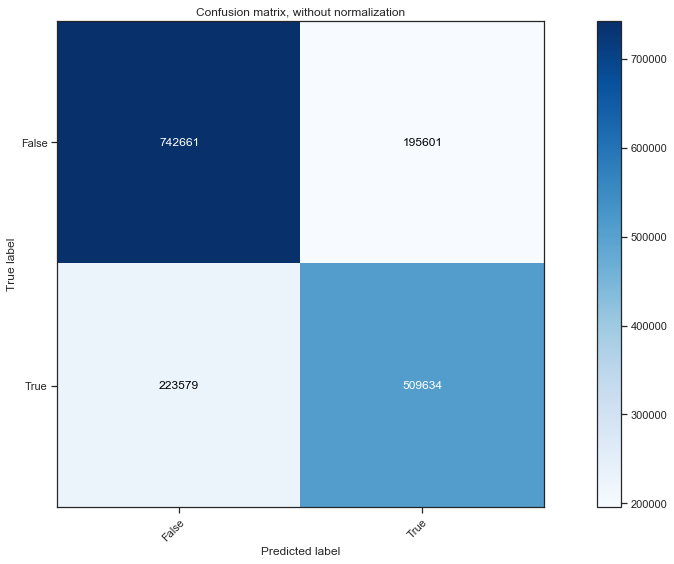

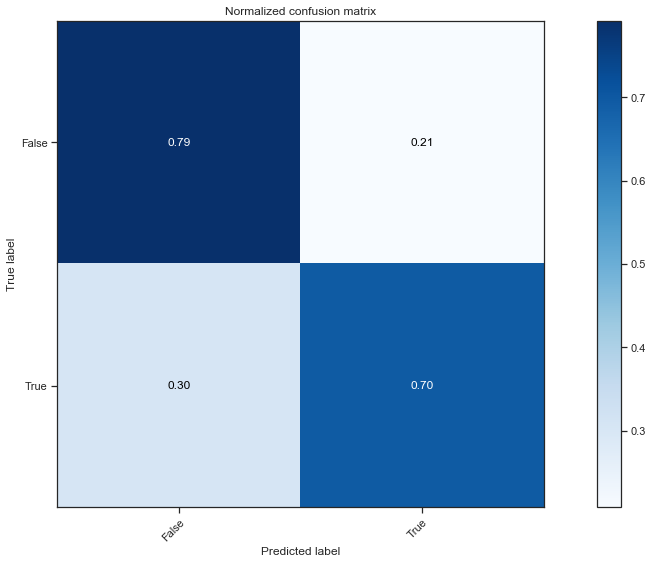

In [56]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import numpy as np

np.set_printoptions(precision=2)

# Only use the labels that appear in the data
classes = unique_labels(y_test, y_pred)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, classes,
                      title='Confusion matrix, without normalization', normalize=False)

# Plot normalized confusion matrix
plot_confusion_matrix(cm, classes,
                      title='Normalized confusion matrix', normalize=True)

plt.show()

## 5.3 Cross Validation and ROC AUC

Cross Validation: Hold out a portion of the training data for model validation, and do this for `K_FOLD`.
- Ensure that the model does not overfit the training data.
- Select optimal model parameters.

We look at some commonly used metrics for binary classification problem:
- Accuracy: percentage of labels correctly predicted. The higher the better.
- ROC AUC: ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. "AUC" ("Area Under Curve”). The higher the better.

In [57]:
from sklearn.model_selection import cross_validate

# Function used to calculate and print cross-validation scores
def training_score(est, X, y, cv):
    scores = cross_validate(est, X, y, cv=cv, scoring=['accuracy', 'roc_auc'])
    acc, roc = scores['test_accuracy'], scores['test_roc_auc']
    print(f"{cv}-fold Train Cross Validation | " \
          f"Accuracy: {round(np.mean(acc), 3)} +/- {round(np.std(acc), 3)} | " \
          f"ROC AUC: {round(np.mean(roc), 3)} +/- {round(np.std(roc), 3)}")

In [58]:
%%time
K_FOLD = 5
training_score(est=lrc, X=X_train_scaled, y=y_train, cv=K_FOLD)

5-fold Train Cross Validation | Accuracy: 0.749 +/- 0.0 | ROC AUC: 0.829 +/- 0.0
CPU times: user 10min 23s, sys: 24.2 s, total: 10min 47s
Wall time: 2min 10s


In [59]:
# Adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

def plot_roc_cv(classifier, X, y, n_splits):
    cv = StratifiedKFold(n_splits=n_splits)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

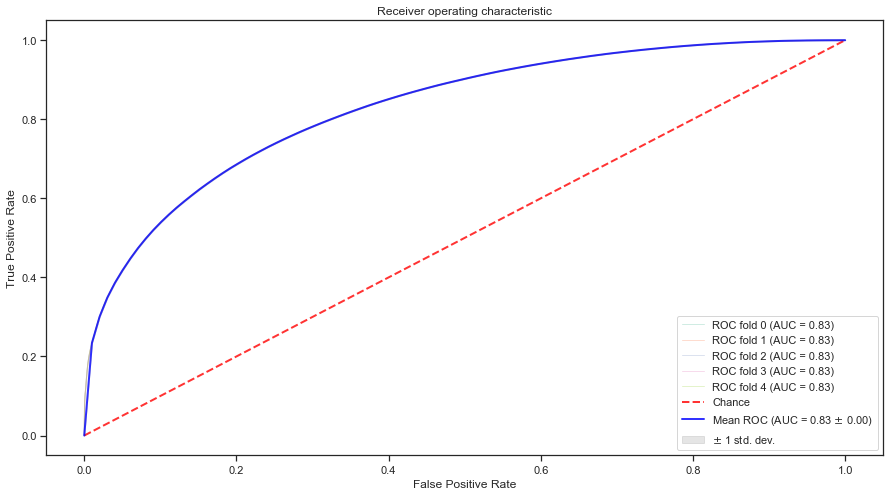

CPU times: user 10min 4s, sys: 14.1 s, total: 10min 18s
Wall time: 1min 52s


In [60]:
%%time
# Run classifier with cross-validation and plot ROC curves
plot_roc_cv(classifier=lrc, X=X_train_scaled, y=y_train, n_splits=K_FOLD)

# Step 6 & Beyond: Iterate Through the Process

First trial usually won’t be the best. We usually do multiple iterations. Each time we look at the features, find out feature correlations, add / remove / adjust feature representation, change the model to use, or do parameter tuning for the model, etc. 